In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer, AutoModel, BertTokenizerFast
device = 'cuda'

### Data Preprocessing

In [113]:
# Import dataset
df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/en_train.csv', encoding='latin-1')
df = df.iloc[:,[1,3]]
df = df.dropna()
df = df[:100000]

In [114]:
# Converting labels to numerical value
def to_numerical(text):
  if text == 'positive':
    return 2
  elif text == 'negative':
    return 1
  else:
    return 0

df.sentiment = df.sentiment.apply(to_numerical)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on t...",1


(array([11117.,     0.,     0.,     0.,     0.,  7781.,     0.,     0.,
            0.,  8582.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

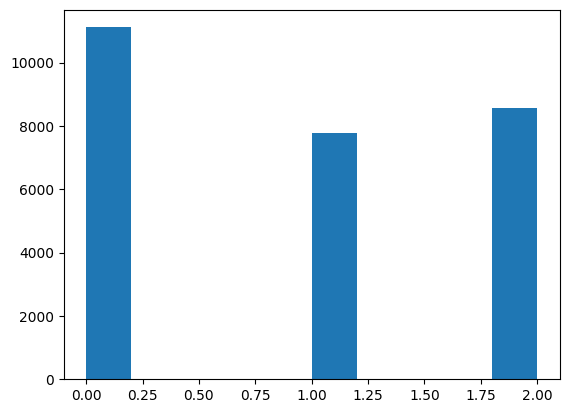

In [115]:
plt.hist(df['sentiment'])

In [116]:
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['sentiment'],
																	random_state = 2021,
																	test_size = 0.2,
																	stratify = df['sentiment'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
																random_state = 2021,
																test_size = 0.5,
																stratify = temp_labels)

In [117]:
# Import pretrained Roberta model
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

# Import pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment",return_dict=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

In [118]:
# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [119]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Create DataLoaders

In [120]:
#### Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Freeze Roberta Parameters

In [121]:
# freeze all the parameters
for param in roberta.parameters():
    param.requires_grad = False

### Define model architecture

In [122]:
class Arch(nn.Module):

    def __init__(self, roberta):
      
      super(Arch, self).__init__()

      self.roberta = roberta 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()
      
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.roberta(sent_id, attention_mask=mask, return_dict=False)

      # dense layer 1
      x = self.fc1(cls_hs)

      x = self.relu(x)

      # dropout layer
      x = self.dropout(x)

      # dense layer (output layer)
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [123]:
# pass the pre-trained Roberta to our define architecture
model = Arch(roberta)

# push the model to GPU
model = model.to(device)

In [124]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Find Class Weights

In [125]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.82392624 1.17718876 1.06744355]


In [126]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

### Fine-tune

In [127]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [128]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    ##################################################
    # Progress update every 50 batches.
    #if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
     # elapsed = format_time(time.time() - t0)
    
      # Report progress.
     # print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start Model Training

In [129]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/english_saved_weights_10k.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    687.
  Batch   100  of    687.
  Batch   150  of    687.
  Batch   200  of    687.
  Batch   250  of    687.
  Batch   300  of    687.
  Batch   350  of    687.
  Batch   400  of    687.
  Batch   450  of    687.
  Batch   500  of    687.
  Batch   550  of    687.
  Batch   600  of    687.
  Batch   650  of    687.

Evaluating...

Training Loss: 0.592
Validation Loss: 0.578

 Epoch 2 / 10
  Batch    50  of    687.
  Batch   100  of    687.
  Batch   150  of    687.
  Batch   200  of    687.
  Batch   250  of    687.
  Batch   300  of    687.
  Batch   350  of    687.
  Batch   400  of    687.
  Batch   450  of    687.
  Batch   500  of    687.
  Batch   550  of    687.
  Batch   600  of    687.
  Batch   650  of    687.

Evaluating...

Training Loss: 0.566
Validation Loss: 0.571

 Epoch 3 / 10
  Batch    50  of    687.
  Batch   100  of    687.
  Batch   150  of    687.
  Batch   200  of    687.
  Batch   250  of    687.
  Batch   300  of    687.
  B

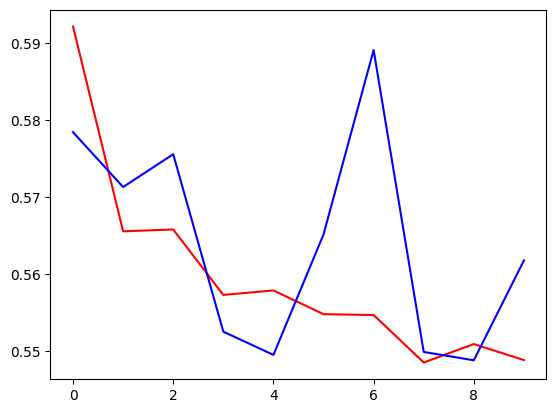

In [130]:
import matplotlib.pyplot as plt

plt.plot(train_losses, color='r')
plt.plot(valid_losses, color='b')

### Get predictions for test data

In [131]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

# Labelling
predicted_label = []
for pred in preds:
  predicted_label.append(np.argmax(pred))

In [132]:
# confusion matrix
pd.crosstab(test_y, predicted_label)

col_0,0,1,2
row_0,,,
0,643,341,128
1,52,705,21
2,113,44,701


In [133]:
from sklearn.metrics import classification_report

target_names = ['NEUTRAL', 'NEGATIVE', 'POSITIVE']
print(classification_report(test_y, predicted_label, target_names=target_names))

              precision    recall  f1-score   support

     NEUTRAL       0.80      0.58      0.67      1112
    NEGATIVE       0.65      0.91      0.75       778
    POSITIVE       0.82      0.82      0.82       858

    accuracy                           0.75      2748
   macro avg       0.76      0.77      0.75      2748
weighted avg       0.76      0.75      0.74      2748



### Define pred function

In [134]:
# Define predict function (2=>POSITIVE 1=>NEGATIVE 0=>NEUTRAL)
def predict_sentiment(text):
  tokenized = tokenizer.encode_plus(
    text,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
    )

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']

  seq = torch.tensor(input_ids)
  mask = torch.tensor(attention_mask)
  seq = seq.unsqueeze(0)
  mask = mask.unsqueeze(0)
  preds = model(seq.to(device), mask.to(device))
  preds = preds.detach().cpu().numpy()
  result = np.argmax(preds, axis=1)
  preds = torch.tensor(preds)
  probabilities = nn.functional.softmax(preds)

  return {'POSITIVE':float(probabilities[0][2]),
          'NEGATIVE':float(probabilities[0][1]),
          'NEUTRAL':float(probabilities[0][0])}
  
  if result == 2:
    return {'Label':'POSITIVE', 'Ratio':float(probabilities[0][2])}
  elif result == 1:
    return {'Label':'NEGATIVE', 'Ratio':float(probabilities[0][1])}
  else:
    return {'Label':'NEUTRAL', 'Ratio':float(probabilities[0][0])}